In [ ]:
# Cài thư viện cần thiết
!pip install PyPortfolioOpt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 12.2 MB/s eta 0:00:00


In [ ]:
# Google Colab cần cài PyPortfolioOpt nếu chưa có
!pip install PyPortfolioOpt

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import expected_returns, risk_models
from pypfopt.risk_models import sample_cov
from pypfopt import plotting
from pypfopt.objective_functions import L2_reg

import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 7.9 MB/s eta 0:00:00


In [ ]:
# BƯỚC 3: Đọc dữ liệu từ file CSV
path = r"/content/Data_of_price(1_year).csv"  # đổi đường dẫn đúng với bạn
df = pd.read_csv(path)



(390, 3)


<Figure size 1000x600 with 0 Axes>

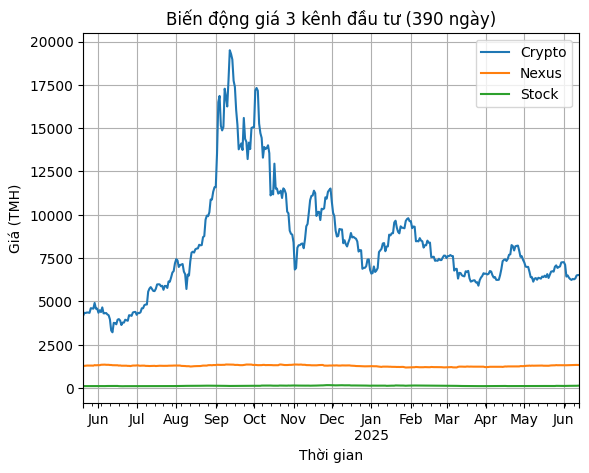

In [ ]:
# Giả sử bạn đã upload file CSV chứa 390 ngày dữ liệu lên Colab
#from google.colab import files
#uploaded = files.upload()

# Đọc dữ liệu
#df = pd.read_csv(next(iter(uploaded)))

# Đổi tên cột cho rõ ràng nếu cần
df.columns = ['Time', 'Crypto', 'Nexus_Buy', 'Nexus_Sell', 'Stock']

# Chọn giá đại diện để tính lợi nhuận
df['Nexus'] = df['Nexus_Sell']

df = df[['Time', 'Crypto', 'Nexus', 'Stock']]

# Chuyển định dạng ngày tháng nếu cần
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
df = df.fillna(method='ffill')    # Forward fill
print(df.shape)
# Giữ lại các cột cần thiết
#asset_prices = df[['Crypto', 'Nexus', 'Stock']]
# Biểu đồ giá
plt.figure(figsize=(10, 6))
df.plot()
plt.title("Biến động giá 3 kênh đầu tư (390 ngày)")
plt.xlabel("Thời gian")
plt.ylabel("Giá (TMH)")
plt.grid(True)
plt.show()

In [ ]:
# Lợi suất logarit hàng ngày
# returns = np.log(asset_prices / asset_prices.shift(1)).dropna()
returns = np.log(df / df.shift(1)).dropna()
# returns = df.pct_change().dropna()
returns['Saving'] = np.log(1 + 0.075)/365 # log return của lãi suất ngân hàng
print(returns)

mu = expected_returns.mean_historical_return(df, frequency=returns.shape[0], compounding=True)
S = risk_models.sample_cov(df, returns_data=False, frequency=returns.shape[0], log_returns=True)

# Thêm kênh tiết kiệm với lợi suất cố định 7.5%
mu['Saving'] = 0.075
S.loc['Saving'] = 0
S['Saving'] = 0
S.loc['Saving', 'Saving'] = 1e-10  # tránh ma trận suy biến

# In lợi suất kỳ vọng
print("Lợi suất kỳ vọng các kênh đầu tư:")
print(mu.round(5))

              Crypto     Nexus     Stock    Saving
Time                                              
2024-05-21  0.038845  0.004031  0.013178  0.000198
2024-05-22 -0.001971  0.007936 -0.040003  0.000198
2024-05-23  0.006614  0.007226  0.004229  0.000198
2024-05-24 -0.001424  0.000239 -0.012736  0.000198
2024-05-25 -0.003510  0.000000  0.000000  0.000198
...              ...       ...       ...       ...
2025-06-09 -0.003689  0.007073  0.030113  0.000198
2025-06-10  0.008398 -0.003906 -0.015309  0.000198
2025-06-11  0.026983  0.001606  0.009929  0.000198
2025-06-12  0.003010 -0.003877  0.038140  0.000198
2025-06-13  0.000573 -0.001205  0.027408  0.000198

[389 rows x 4 columns]
Lợi suất kỳ vọng các kênh đầu tư:
Crypto    0.56227
Nexus     0.04258
Stock     0.22145
Saving    0.07500
dtype: float64


In [ ]:
# TỐI ƯU DANH MỤC ĐẦU TƯ

risk_free_rate = 0.05

def print_result(title, ef):
    print(f"\n🔹 {title}")
    weights = ef.clean_weights()
    for asset, w in weights.items():
        print(f"{asset}: {round(w * 100, 2)}%")
    perf = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)

    w_opt = np.array(list(weights.values()))
    expected_return =  (w_opt @ mu)
    volatility = np.sqrt(w_opt @ S @ w_opt)
    sharpe = (expected_return - risk_free_rate) / volatility

    print(f"Expected anual return: {expected_return*100:.2f}% ")
    print(f"Anual votality: {volatility * 100:.2f}%")
    print(f"Sharpe: {sharpe:.2f}")

    return weights, perf

# --- 1. Danh mục có rủi ro thấp nhất (min volatility)
ef_min_vol = EfficientFrontier(mu, S)
ef_min_vol.add_constraint(lambda w: w >= 0)
ef_min_vol.min_volatility()
weights_min_vol, perf_min_vol = print_result("Min Volatility Portfolio", ef_min_vol)

# --- 2. Danh mục giới hạn rủi ro ở mức 15% (efficient risk)
target_vol = 0.15
ef_risk_constrained = EfficientFrontier(mu, S)
ef_risk_constrained.add_constraint(lambda w: w >= 0)
ef_risk_constrained.efficient_risk(target_volatility=target_vol)
weights_risk_constrained, perf_risk_constrained = print_result(f"Efficient Portfolio (≤ {int(target_vol*100)}% Volatility)", ef_risk_constrained)

# --- 3. Danh mục tối đa hóa Sharpe (chỉ để tham khảo nếu rủi ro cao)
ef_max_sharpe = EfficientFrontier(mu, S)
ef_max_sharpe.add_constraint(lambda w: w >= 0)
ef_max_sharpe.max_sharpe(risk_free_rate=risk_free_rate)
weights_max_sharpe, perf_max_sharpe = print_result("Max Sharpe Ratio Portfolio", ef_max_sharpe)

# --- 4. Tối đa hóa quadratic
ef_quadratic = EfficientFrontier(mu, S)
ef_quadratic.max_quadratic_utility(risk_aversion=20)
weights_quadratic, perf_max_sharpe = print_result("Quadratic Portfolio", ef_quadratic)

# ---- 5. Quadratic + bayesian
T, n = returns.shape[0], 4

# Prior
mu0 = np.zeros(n)
kappa0 = 0.01
nu0 = n + 2
psi0 = np.eye(n) * 0.001

# Tính hậu nghiệm
x_bar = returns.mean(axis=0)
s = np.cov(returns.T, bias=False)
assets = ['Crypto', 'Nexus', 'Stock', 'Saving']
s = pd.DataFrame(s, index=assets, columns=assets)

kappa_n = kappa0 + T
mu_n =  (kappa0 * mu0 + T * x_bar) / kappa_n

nu_n = nu0 + T
psi_n = psi0 + s * T + (kappa0 * T) / (kappa0 + T) * np.outer((x_bar - mu0), (x_bar - mu0))

# Ước lượng posterior mean cho Sigma là kỳ vọng của IW
Sigma_post = psi_n / (nu_n - n - 1)

ef_bayes = EfficientFrontier(mu_n, Sigma_post)
ef_bayes.max_quadratic_utility(risk_aversion=20)
weights_bayes, perf_bayes = print_result("Bayesian Portfolio", ef_bayes)

#


🔹 Min Volatility Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2500.00

🔹 Efficient Portfolio (≤ 15% Volatility)
Crypto: 12.68%
Nexus: 0.0%
Stock: 20.73%
Saving: 66.59%
Expected anual return: 16.72% 
Anual votality: 15.00%
Sharpe: 0.78

🔹 Max Sharpe Ratio Portfolio
Crypto: 0.0%
Nexus: 0.0%
Stock: 0.0%
Saving: 100.0%
Expected anual return: 7.50% 
Anual votality: 0.00%
Sharpe: 2499.95

🔹 Quadratic Portfolio
Crypto: 2.6%
Nexus: 0.0%
Stock: 4.25%
Saving: 93.16%
Expected anual return: 9.39% 
Anual votality: 3.07%
Sharpe: 1.43

🔹 Bayesian Portfolio
Crypto: 2.07%
Nexus: 0.0%
Stock: 4.11%
Saving: 93.82%
Expected anual return: 9.11% 
Anual votality: 2.63%
Sharpe: 1.56


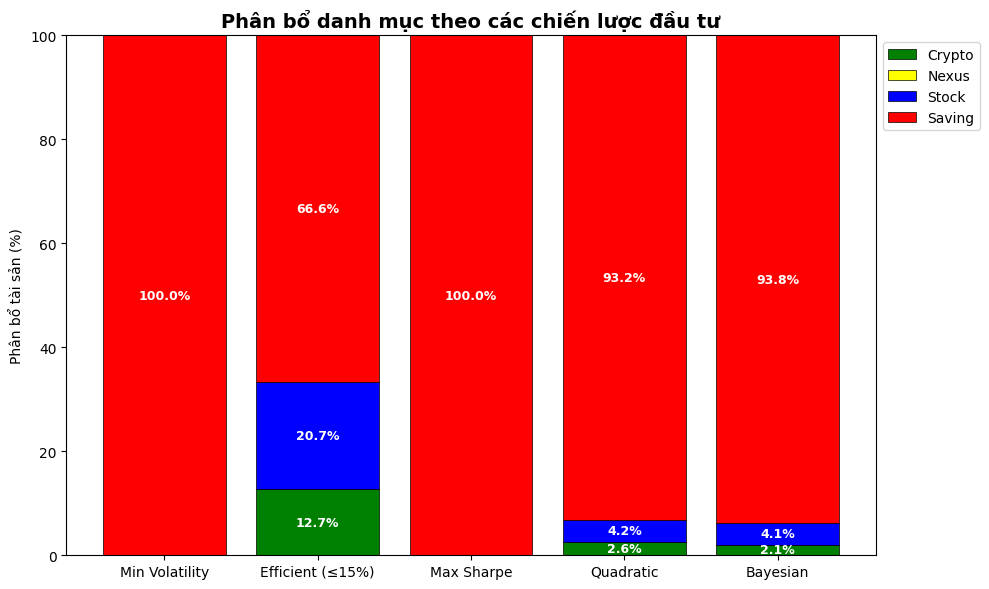

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu phân bổ danh mục
portfolios = {
    "Min Volatility": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 100.0},
    "Efficient (≤15%)": {"Crypto": 12.68, "Nexus": 0.0, "Stock": 20.73, "Saving": 66.59},
    "Max Sharpe": {"Crypto": 0.0, "Nexus": 0.0, "Stock": 0.0, "Saving": 100.0},
    "Quadratic": {"Crypto": 2.60, "Nexus": 0.0, "Stock": 4.25, "Saving": 93.16},
    "Bayesian": {"Crypto": 2.07, "Nexus": 0.0, "Stock": 4.11, "Saving": 93.82},
}

# Chuyển thành danh sách theo tài sản
assets = ["Crypto", "Nexus", "Stock", "Saving"]
colors = ["green", "yellow", "blue", "red"]
port_names = list(portfolios.keys())
data = np.array([[p[asset] for asset in assets] for p in portfolios.values()])

# Vẽ biểu đồ cột chồng (stacked bar chart)
fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(port_names))

for i, asset in enumerate(assets):
    ax.bar(port_names, data[:, i], bottom=bottom, label=asset, color=colors[i], edgecolor='black', linewidth=0.5)
    bottom += data[:, i]

# Thêm nhãn phần trăm tại mỗi lớp
for idx, portfolio in enumerate(port_names):
    cumulative = 0
    for i, asset in enumerate(assets):
        value = portfolios[portfolio][asset]
        if value > 1:  # Chỉ hiển thị nếu > 1% để tránh chen chúc
            ax.text(idx, cumulative + value / 2, f"{value:.1f}%",
                    ha='center', va='center', fontsize=9, color="white", fontweight='bold')
        cumulative += value

# Định dạng trục
ax.set_ylabel('Phân bổ tài sản (%)')
ax.set_title('Phân bổ danh mục theo các chiến lược đầu tư', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Hiển thị huyền thoại
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Căn chỉnh layout để không bị che
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(f"a.jpg")
# Hiển thị
plt.show()

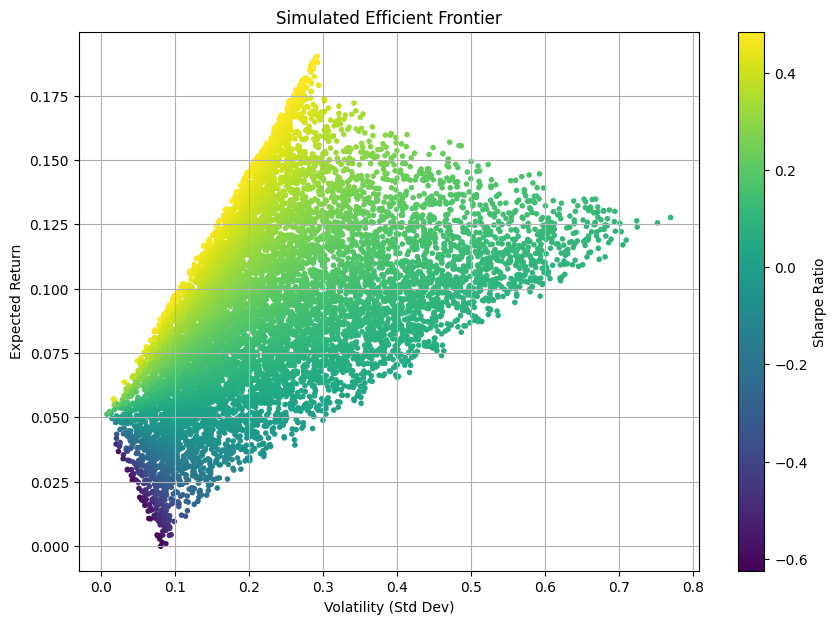

In [ ]:
# Tự dựng đường biên từ returns và weights ngẫu nhiên
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(len(returns.columns)), size=1)[0]
    weights_record.append(weights)
    portfolio_return = np.dot(weights, returns.mean()) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev

# Vẽ bằng matplotlib
plt.figure(figsize=(10,7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='.')
plt.xlabel('Volatility (Std Dev)')
plt.ylabel('Expected Return')
plt.title('Simulated Efficient Frontier')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()


**Yêu** **cầu** **3**

In [ ]:
# ========================
# YÊU CẦU 3: ĐÁNH GIÁ MAX DRAWDOWN
# ========================

def calculate_portfolio_nav(returns_df, weights):
    """Tính giá trị danh mục đầu tư qua thời gian (NAV) từ log returns và tỷ trọng."""
    weighted_returns = returns_df @ np.array(list(weights.values()))
    cumulative_returns = np.exp(weighted_returns[:365].cumsum())
    return cumulative_returns

def calculate_max_drawdown(nav_series):
    """Tính mức sụt giảm lớn nhất (Max Drawdown)."""
    peak = nav_series.cummax()
    drawdown = (nav_series - peak) / peak
    max_dd = drawdown.min()
    return max_dd

# Bổ sung lợi suất hàng ngày của kênh Saving (hằng số)
daily_saving_return = np.log(1 + 0.075)/365
returns_with_saving = returns.copy()
returns_with_saving['Saving'] = daily_saving_return

# Danh sách các danh mục đầu tư cần đánh giá
portfolios = [
    ("Min Volatility Portfolio", weights_min_vol),
    ("Efficient Portfolio (≤ 15% Volatility)", weights_risk_constrained),
    ("Max Sharpe Ratio Portfolio", weights_max_sharpe),
    ("Quadratic Portfolio", weights_quadratic),
    ("Bayesian Portfolio", weights_bayes)
]

print("\n======================")
print("ĐÁNH GIÁ MỨC SỤT GIẢM LỚN NHẤT (MAX DRAWDOWN)")
print("======================\n")

for name, weights in portfolios:
    nav = calculate_portfolio_nav(returns_with_saving, weights)
    max_dd = calculate_max_drawdown(nav)
    final_return = nav.iloc[-1] - 1
    print(f"🔸 {name}")
    print(f"  - Lợi suất thực tế sau 1 năm: {final_return:.2%}")
    print(f"  - Mức sụt giảm lớn nhất (Max Drawdown): {max_dd:.2%}\n")



ĐÁNH GIÁ MỨC SỤT GIẢM LỚN NHẤT (MAX DRAWDOWN)

🔸 Min Volatility Portfolio
  - Lợi suất thực tế sau 1 năm: 7.50%
  - Mức sụt giảm lớn nhất (Max Drawdown): 0.00%

🔸 Efficient Portfolio (≤ 15% Volatility)
  - Lợi suất thực tế sau 1 năm: 10.94%
  - Mức sụt giảm lớn nhất (Max Drawdown): -14.30%

🔸 Max Sharpe Ratio Portfolio
  - Lợi suất thực tế sau 1 năm: 7.50%
  - Mức sụt giảm lớn nhất (Max Drawdown): 0.00%

🔸 Quadratic Portfolio
  - Lợi suất thực tế sau 1 năm: 8.20%
  - Mức sụt giảm lớn nhất (Max Drawdown): -1.71%

🔸 Bayesian Portfolio
  - Lợi suất thực tế sau 1 năm: 8.00%
  - Mức sụt giảm lớn nhất (Max Drawdown): -1.40%



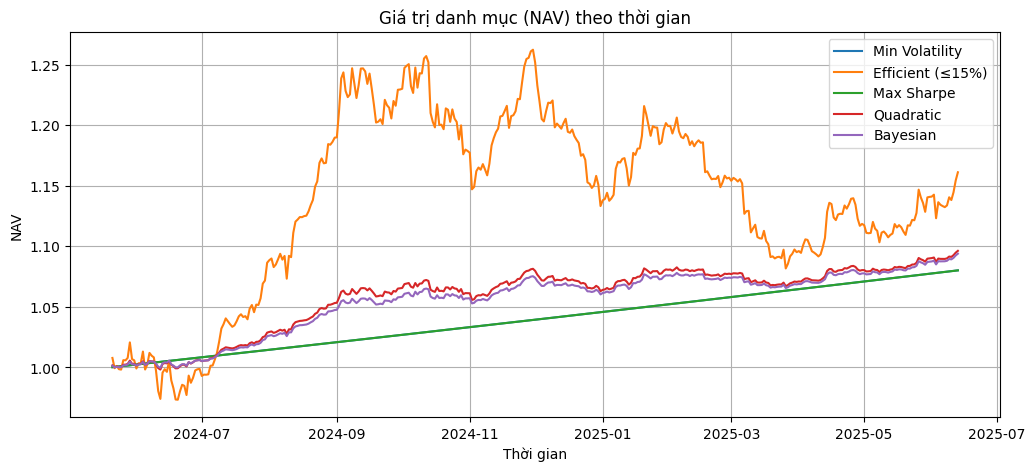

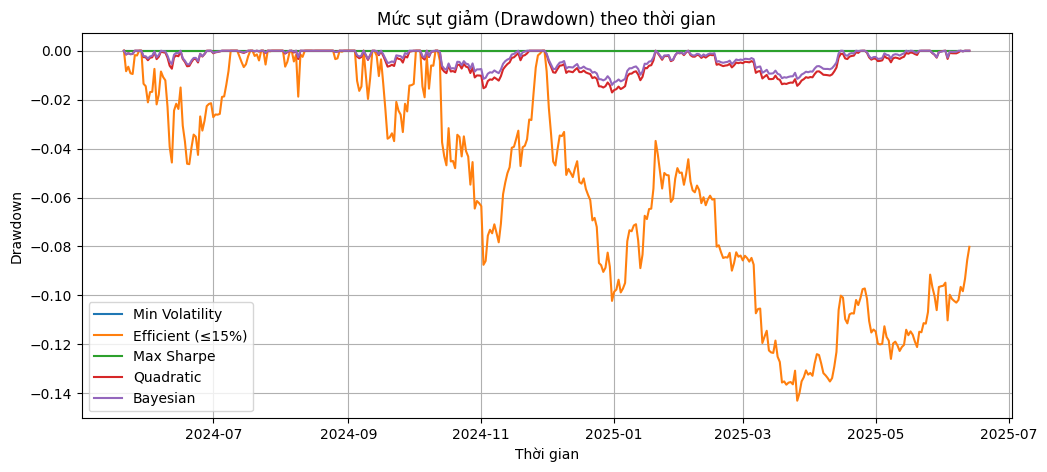

🛑 Thời điểm sụt giảm mạnh nhất:
- Min Volatility: 2024-05-21 (0.00%)
- Efficient (≤15%): 2025-03-26 (-14.30%)
- Max Sharpe: 2024-05-21 (0.00%)
- Quadratic: 2024-12-31 (-1.71%)
- Bayesian: 2024-12-31 (-1.40%)


In [ ]:
# Hàm tính NAV theo thời gian
def compute_nav(returns, weights):
    weights = pd.Series(weights).reindex(returns.columns).fillna(0)
    portfolio_returns = returns.dot(weights)
    nav = np.exp(portfolio_returns.cumsum())
    return nav

# Hàm tính drawdown
def compute_drawdown(nav):
    peak = nav.cummax()
    drawdown = (nav - peak) / peak
    return drawdown

# Tính NAV cho từng danh mục
nav_min_vol = compute_nav(returns, weights_min_vol)
nav_risk_constrained = compute_nav(returns, weights_risk_constrained)
nav_max_sharpe = compute_nav(returns, weights_max_sharpe)
nav_quadratic = compute_nav(returns, weights_quadratic)
nav_bayes = compute_nav(returns, weights_bayes)

# Tính drawdown
dd_min_vol = compute_drawdown(nav_min_vol)
dd_risk_constrained = compute_drawdown(nav_risk_constrained)
dd_max_sharpe = compute_drawdown(nav_max_sharpe)
dd_quadratic = compute_drawdown(nav_quadratic)
dd_bayes = compute_drawdown(nav_bayes)

# Vẽ biểu đồ NAV
plt.figure(figsize=(12, 5))
plt.plot(nav_min_vol, label="Min Volatility")
plt.plot(nav_risk_constrained, label="Efficient (≤15%)")
plt.plot(nav_max_sharpe, label="Max Sharpe")
plt.plot(nav_quadratic, label="Quadratic")
plt.plot(nav_bayes, label="Bayesian")
plt.title("Giá trị danh mục (NAV) theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("NAV")
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ Drawdown
plt.figure(figsize=(12, 5))
plt.plot(dd_min_vol, label="Min Volatility")
plt.plot(dd_risk_constrained, label="Efficient (≤15%)")
plt.plot(dd_max_sharpe, label="Max Sharpe")
plt.plot(dd_quadratic, label="Quadratic")
plt.plot(dd_bayes, label="Bayesian")
plt.title("Mức sụt giảm (Drawdown) theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()

# Xem thời điểm sụt giảm lớn nhất
print("🛑 Thời điểm sụt giảm mạnh nhất:")
print(f"- Min Volatility: {dd_min_vol.idxmin().date()} ({dd_min_vol.min():.2%})")
print(f"- Efficient (≤15%): {dd_risk_constrained.idxmin().date()} ({dd_risk_constrained.min():.2%})")
print(f"- Max Sharpe: {dd_max_sharpe.idxmin().date()} ({dd_max_sharpe.min():.2%})")
print(f"- Quadratic: {dd_quadratic.idxmin().date()} ({dd_quadratic.min():.2%})")
print(f"- Bayesian: {dd_bayes.idxmin().date()} ({dd_bayes.min():.2%})")


In [ ]:
# Thêm lợi suất cố định cho Saving (nếu chưa có trong returns)
if 'Saving' not in returns.columns:
    daily_saving_return = (1 + 0.075)**(1/390) - 1
    returns['Saving'] = daily_saving_return

# Hàm tính NAV và drawdown từ returns và weights
def compute_nav(returns_df, weights_dict):
    weights_vector = np.array([weights_dict[col] for col in returns_df.columns])
    daily_returns = returns_df.dot(weights_vector)
    nav = np.exp(daily_returns.cumsum())
    return nav

def compute_drawdown(nav_series):
    running_max = nav_series.cummax()
    drawdown = nav_series / running_max - 1
    return drawdown


In [ ]:
# Tính NAV cho từng danh mục
nav_min_vol = compute_nav(returns, weights_min_vol)
nav_risk_constrained = compute_nav(returns, weights_risk_constrained)
nav_max_sharpe = compute_nav(returns, weights_max_sharpe)
nav_quadratic = compute_nav(returns, weights_quadratic)
nav_bayes = compute_nav(returns, weights_bayes)
# Tính drawdown cho từng danh mục
dd_min_vol = compute_drawdown(nav_min_vol)
dd_risk_constrained = compute_drawdown(nav_risk_constrained)
dd_max_sharpe = compute_drawdown(nav_max_sharpe)
dd_quadratic = compute_drawdown(nav_quadratic)
dd_bayes = compute_drawdown(nav_bayes)


In [ ]:
print("===== Thời điểm sụt giảm mạnh nhất =====")
print(f"- Min Volatility: {dd_min_vol.idxmin().date()} ({dd_min_vol.min():.2%})")
print(f"- Efficient (≤15%): {dd_risk_constrained.idxmin().date()} ({dd_risk_constrained.min():.2%})")
print(f"- Max Sharpe: {dd_max_sharpe.idxmin().date()} ({dd_max_sharpe.min():.2%})")
print(f"- Quadratic: {dd_quadratic.idxmin().date()} ({dd_quadratic.min():.2%})")
print(f"- Bayesian: {dd_bayes.idxmin().date()} ({dd_bayes.min():.2%})")


===== Thời điểm sụt giảm mạnh nhất =====
- Min Volatility: 2024-05-21 (0.00%)
- Efficient (≤15%): 2025-03-26 (-14.30%)
- Max Sharpe: 2024-05-21 (0.00%)
- Quadratic: 2024-12-31 (-1.71%)
- Bayesian: 2024-12-31 (-1.40%)


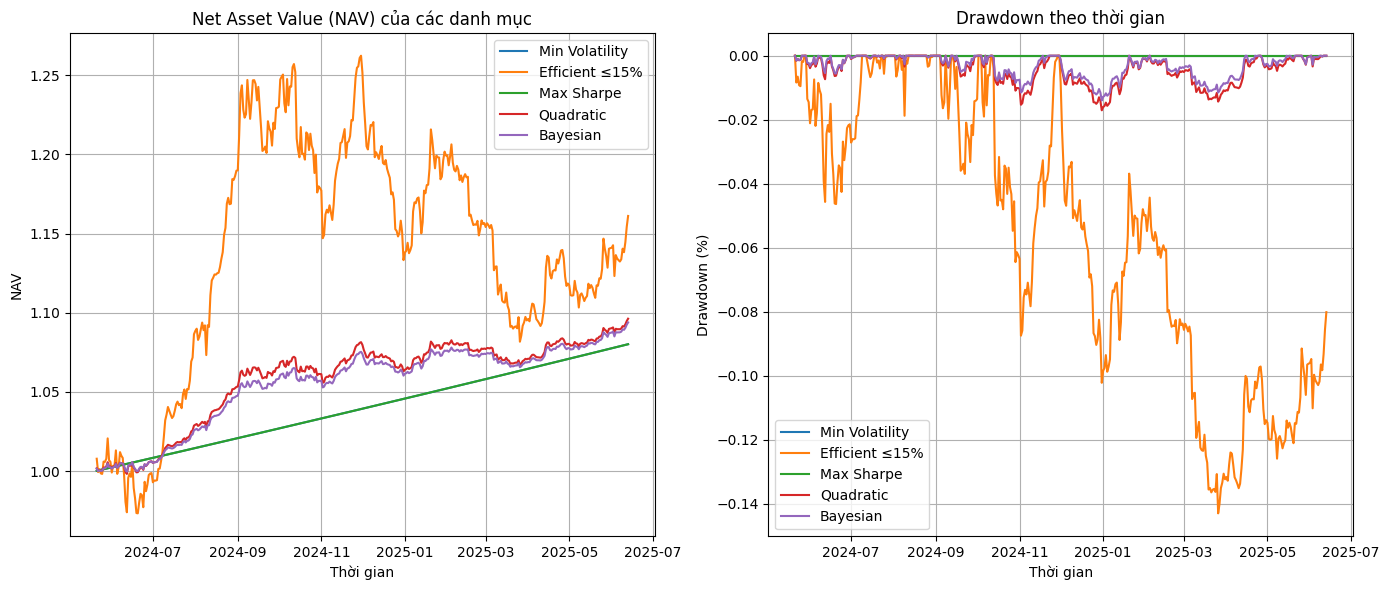

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# NAV chart
plt.subplot(1, 2, 1)
plt.plot(nav_min_vol, label='Min Volatility')
plt.plot(nav_risk_constrained, label='Efficient ≤15%')
plt.plot(nav_max_sharpe, label='Max Sharpe')
plt.plot(nav_quadratic, label='Quadratic')
plt.plot(nav_bayes, label='Bayesian')
plt.title("Net Asset Value (NAV) của các danh mục")
plt.xlabel("Thời gian")
plt.ylabel("NAV")
plt.legend()
plt.grid(True)

# Drawdown chart
plt.subplot(1, 2, 2)
plt.plot(dd_min_vol, label='Min Volatility')
plt.plot(dd_risk_constrained, label='Efficient ≤15%')
plt.plot(dd_max_sharpe, label='Max Sharpe')
plt.plot(dd_quadratic, label='Quadratic')
plt.plot(dd_bayes, label='Bayesian')
plt.title("Drawdown theo thời gian")
plt.xlabel("Thời gian")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Xem thời điểm sụt giảm lớn nhất
print("🛑 Thời điểm sụt giảm mạnh nhất:")
print(f"- Min Volatility: {dd_min_vol.idxmin().date()} ({dd_min_vol.min():.2%})")
print(f"- Efficient (≤15%): {dd_risk_constrained.idxmin().date()} ({dd_risk_constrained.min():.2%})")
print(f"- Max Sharpe: {dd_max_sharpe.idxmin().date()} ({dd_max_sharpe.min():.2%})")
print(f"- Quadratic: {dd_quadratic.idxmin().date()} ({dd_quadratic.min():.2%})")
print(f"- Bayesian: {dd_bayes.idxmin().date()} ({dd_bayes.min():.2%})")

🛑 Thời điểm sụt giảm mạnh nhất:
- Min Volatility: 2024-05-21 (0.00%)
- Efficient (≤15%): 2025-03-26 (-14.30%)
- Max Sharpe: 2024-05-21 (0.00%)
- Quadratic: 2024-12-31 (-1.71%)
- Bayesian: 2024-12-31 (-1.40%
